In [1]:
import pandas as pd
import numpy as np
np.random.seed(2700)

Я заниюмаюсь управлением товародвижения в федеральной сети ювелирных магазинов (1000 магазинов). Отвечаю за изделия из золота. В данной работе хочу применить машинное обучение и гео - визуализацию на питоне для:

- прогноза продаж ассортимента определенного типа для каждого торгового объекта(магазина) в отдельности
- выявление главных признаков торгового объекта(магазина), котороые влияют на продажи ассортимента определенного типа

Делать это буду на примере мусульманских подвесов.
Для анализа буду использовать данные по продажам мусульманских подвесов из серебра, т.к. они присутствуют почти в каждом магазине.
Практическая польза: формирование точной ассортиментной матрицы на этапе подготовки новых магазинов к открытию, что в свою очередь позволит товарным остаткам "работать" максимально эффективно

In [2]:

#Данные с продажами и остатками 2019 год по золоту и серебру помесячно
path = 'C:/нетология/muslim.xlsx'

sales = pd.read_excel(path, sheet_name='олап', skiprows=13,usecols=list(range(0,26)))
stock = pd.read_excel(path, sheet_name='олап', skiprows=13,usecols=list(range(27,53)), names = sales.columns.tolist())
sales = sales.iloc[:sales.Склад.to_list().index('Общий итог')]
stock = stock.iloc[:stock.Склад.to_list().index('Общий итог')]

# меняем все отрицательные(ошибочные) продажи на ноль
num = sales._get_numeric_data()
num[num < 0] = 0 

gold = [x for x in sales.columns.tolist() if '.1' not in x or x in ['Склад','Название']]
silver = [x for x in sales.columns.tolist() if '.1' in x or x in ['Склад','Название']]

# отделяем остатки, продажи, золото, серебро
sales_gold = sales[gold]
sales_silver = sales[silver]
stock_gold = stock[gold]
stock_silver = stock[silver]

stock_gold.columns = sales_gold.columns
stock_silver.columns = sales_gold.columns
sales_silver.columns = sales_gold.columns



In [3]:
# Полезные функции и переменные
quarter_dict = {'квартал1': ['Январь,2019', 'Февраль,2019', 'Март,2019'],
                'квартал2': ['Апрель,2019', 'Май,2019', 'Июнь,2019'],
                'квартал3': ['Июль,2019', 'Август,2019', 'Сентябрь,2019'],
                'квартал4': ['Октябрь,2019', 'Ноябрь,2019', 'Декабрь,2019']}

quarter = ['квартал1', 'квартал2', 'квартал3', 'квартал4']

months = ['Январь,2019', 'Февраль,2019', 'Март,2019', 'Апрель,2019', 'Май,2019', 'Июнь,2019',
          'Июль,2019', 'Август,2019', 'Сентябрь,2019', 'Октябрь,2019', 'Ноябрь,2019', 'Декабрь,2019']


def quarter(df):# возвращает датафрейм с продажами по кварталам
    q_list = [x if x in ['Склад','Название'] else df[x].sum(axis=1) for x in list(quarter_dict.values())]
    return pd.DataFrame(dict(zip(quarter, q_list)))
   

In [12]:
# считаем количество магов с остатками больше нуля

pd.DataFrame(index=np.array(months), data=
             {"Количество магов с остатками больше нуля серебро" : np.count_nonzero(stock_silver[months],axis=0),
              "Количество магов с остатками больше нуля золото" : np.count_nonzero(stock_gold[months],axis=0)})


,Количество магов с остатками больше нуля серебро,Количество магов с остатками больше нуля золото
"Январь,2019",910,632
"Февраль,2019",909,626
"Март,2019",917,625
"Апрель,2019",924,629
"Май,2019",921,627
"Июнь,2019",939,633
"Июль,2019",949,771
"Август,2019",955,782
"Сентябрь,2019",967,782
"Октябрь,2019",976,793


In [13]:
permanent = len([x for x in np.count_nonzero(stock_silver[months],axis=1) if x == 12])
lost = sum([x-868 for x  in np.count_nonzero(stock_silver[months],axis=0)])
'Магазинов с остатками больше нуля целый год: {}. Если взять только эти магазины то потеряется {:.0%} данных'.format(permanent, lost/(permanent*12))

'Магазинов с остатками больше нуля целый год: 868. Если взять только эти магазины то потеряется 9% данных'

In [15]:
# По магазинам с остатками по золоту считаем корреляцию продаж золота и серебра помесячно,

stock_gold['остаток месяцев'] = stock_gold[months].astype(bool).sum(axis=1)
sws_m = stock_gold[['Склад']][stock_gold['остаток месяцев'] > 0].merge(sales)
m_corr = pd.Series(index=np.array(months), data=np.diagonal(sws_m.corr().round(decimals=2).iloc[12: , :12].values))

#поквартально,
mlist = list(range(3,25,3))
qdata = [sws_m.iloc[:,x-3:x].sum(axis=1).tolist() for x in mlist]
names = ['квартал1','квартал2','квартал3','квартал4','квартал1s','квартал2s','квартал3s','квартал4s']
sws_q = pd.DataFrame(dict(zip(names,qdata)))
q_corr = pd.Series(index=sws_q.columns.tolist()[:4],data=np.diagonal(sws_q.corr().round(decimals=2).iloc[:4,4:].values))

# годовая
sws_y = pd.DataFrame({'золото' : sws_q.iloc[:,:4].sum(axis=1).tolist(),'серебро' : sws_q.iloc[:,4:].sum(axis=1).tolist()})

print('Маги с остатками по золоту и серебру больше нуля весь год',
      'Корреляция продаж золото-серебро помесячно.',m_corr, 
      'Корреляция продаж золото-серебро поквартально.',q_corr,
      'Корреляция продаж золото-серебро годовая.', sws_y.corr().round(decimals=2).at["золото",'серебро'], sep="\n\n")

Маги с остатками по золоту и серебру больше нуля весь год

Корреляция продаж золото-серебро помесячно.

Январь,2019      0.51
Февраль,2019     0.55
Март,2019        0.54
Апрель,2019      0.43
Май,2019         0.55
Июнь,2019        0.59
Июль,2019        0.57
Август,2019      0.61
Сентябрь,2019    0.53
Октябрь,2019     0.49
Ноябрь,2019      0.47
Декабрь,2019     0.60
dtype: float64

Корреляция продаж золото-серебро поквартально.

квартал1    0.67
квартал2    0.67
квартал3    0.74
квартал4    0.71
dtype: float64

Корреляция продаж золото-серебро годовая.

0.82


C:\Users\Dotsenko.Semen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


По кварталам корреляция оптимальная. Обучение целесообразно делать на квартальных данных.

In [16]:
# Оставляем только магазины, где остатки были весь год
sws_m[sws_m < 0] = 0 # меняем все отрицательные(ошибочные) продажи на ноль
stock_silver_m = stock_silver_m[stock_silver_m.apply(lambda row: np.count_nonzero(row) == 12, axis=1)]

TypeError: '<' not supported between instances of 'str' and 'int'

In [602]:
# Боксплотты и статистики по продажам с разной временной иерархией (месяцы, квартал, год)
sws_m_gold = sws_m[[x for x in sws_m.columns.tolist() if '.1' not in x]]
sws_m_silver = sws_m[[x for x in sws_m.columns.tolist() if '.1' in x]]

sws_q_gold = sws_q[[x for x in sws_q.columns.tolist() if 's' not in x]]
sws_q_silver = sws_q[[x for x in sws_q.columns.tolist() if 's' in x]]

sws_m_silver.columns = sws_m_gold.columns
sws_q_silver.columns = sws_q_gold.columns


In [603]:
gold_m_stat = sws_m_gold.describe().round(decimals=1).T.drop(columns='count')
silver_m_stat = sws_m_silver.describe().round(decimals=1).T.drop(columns='count')
gold_m_stat.columns = pd.MultiIndex.from_product([['Статистика продажи золото'], gold_m_stat.columns.tolist()])
silver_m_stat.columns = pd.MultiIndex.from_product([['Статистика продажи серебро'],silver_m_stat.columns.tolist()])
gold_m_stat.merge(silver_m_stat, left_index=True, right_index=True)


Статистика продажи золото                                 \
                                   mean  std  min  25%  50%  75%   max   
Январь,2019                         1.0  1.8 -1.0  0.0  0.0  1.0  13.0   
Февраль,2019                        1.0  1.7  0.0  0.0  0.0  1.0  11.0   
Март,2019                           1.4  2.2  0.0  0.0  0.0  2.0  15.0   
Апрель,2019                         0.8  1.4  0.0  0.0  0.0  1.0   9.0   
Май,2019                            1.0  1.7  0.0  0.0  0.0  1.0  12.0   
Июнь,2019                           1.2  1.9  0.0  0.0  0.0  2.0  12.0   
Июль,2019                           1.4  2.1  0.0  0.0  0.0  2.0  13.0   
Август,2019                         1.5  2.0 -1.0  0.0  1.0  2.0  12.0   
Сентябрь,2019                       1.2  1.7 -3.0  0.0  1.0  2.0  12.0   
Октябрь,2019                        1.1  1.5  0.0  0.0  0.0  2.0  12.0   
Ноябрь,2019                         1.1  1.5  0.0  0.0  1.0  2.0  11.0   
Декабрь,2019                        2.1  2.5  0.0  0.0  1.0  3.0  19.0   

              Статистика продажи серебро                                 
                                    mean  std  min  25%  50%  75%   max  
Январь,2019                          1.4  2.0  0.0  0.0  1.0  2.0  19.0  
Февраль,2019                         1.6  2.2  0.0  0.0  1.0  2.0  20.0  
Март,2019                            1.6  2.1  0.0  0.0  1.0  2.0  16.0  
Апрель,2019                          1.2  1.6  0.0  0.0  1.0  2.0  11.0  
Май,2019                             1.5  2.2  0.0  0.0  1.0  2.0  19.0  
Июнь,2019                            1.9  2.6  0.0  0.0  1.0  2.0  19.0  
Июль,2019                            2.1  3.0  0.0  0.0  1.0  3.0  21.0  
Август,2019                          2.4  3.2  0.0  0.0  1.0  3.0  24.0  
Сентябрь,2019                        2.2  2.8  0.0  0.0  1.0  3.0  20.0  
Октябрь,2019                         1.9  2.5  0.0  0.0  1.0  3.0  17.0  
Ноябрь,2019                          1.8  2.4 -1.0  0.0  1.0  2.0  21.0  
Декабрь,2019                         3.3  4.2 -1.0  1.0  2.0  4.0  35.0

In [368]:
gold_q_stat = sws_q_gold.describe().round(decimals=1).T.drop(columns='count')
silver_q_stat = sws_q_silver.describe().round(decimals=1).T.drop(columns='count')
gold_q_stat.columns = pd.MultiIndex.from_product([['Статистика продажи золото'], gold_q_stat.columns.tolist()])
silver_q_stat.columns = pd.MultiIndex.from_product([['Статистика продажи серебро'],silver_q_stat.columns.tolist()])
gold_q_stat.merge(silver_q_stat, left_index=True, right_index=True)


Статистика продажи золото                                 \
                              mean  std  min  25%  50%  75%   max   
квартал1                       3.3  4.9  0.0  0.0  1.0  5.0  32.0   
квартал2                       2.9  4.4  0.0  0.0  1.0  4.0  28.0   
квартал3                       4.0  4.9  0.0  1.0  2.0  6.0  31.0   
квартал4                       4.1  4.5  0.0  1.0  3.0  6.0  37.0   

         Статистика продажи серебро                                 
                               mean  std  min  25%  50%  75%   max  
квартал1                        4.6  5.5  0.0  1.0  3.0  6.0  51.0  
квартал2                        4.4  5.5  0.0  1.0  3.0  6.0  39.0  
квартал3                        6.5  8.2  0.0  2.0  4.0  8.0  62.0  
квартал4                        6.8  8.0  0.0  2.0  5.0  9.0  66.0

In [379]:
sws_y.describe().astype('int').T.drop(columns='count')

,mean,std,min,25%,50%,75%,max
золото,14,16,0,3,8,20,109
серебро,22,25,0,8,15,27,210


Text(0.5,1,'Продажи золото по месяцам')

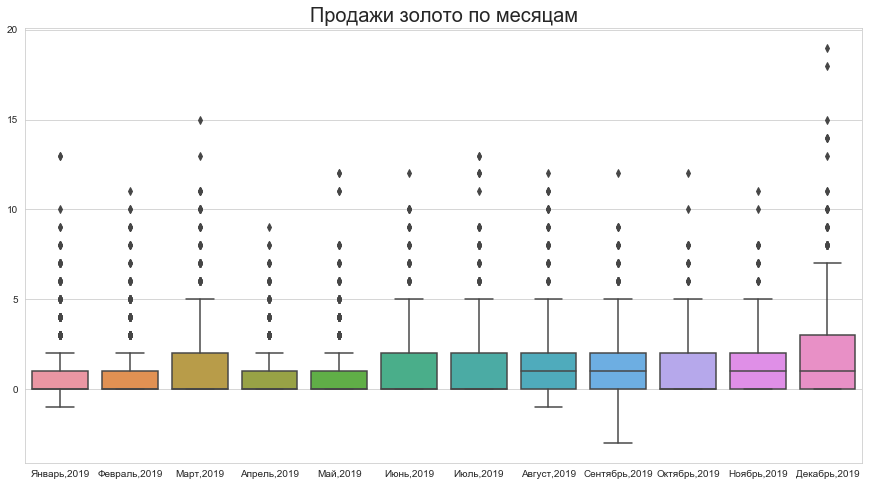

In [477]:
# Боксплотты по продажам с разной временной иерархией (месяцы, квартал, год)
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
sns.boxplot(data=sws_m_gold).set_title("Продажи золото по месяцам", fontsize=20)

Text(0.5,1,'Продажи серебро по месяцам')

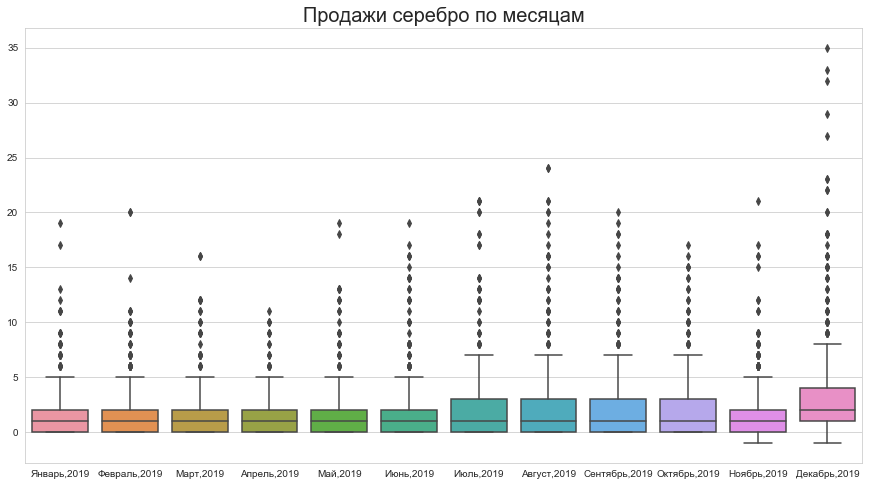

In [517]:
plt.figure(figsize=(15,8))
sns.boxplot(data=sws_m_silver).set_title("Продажи серебро по месяцам", fontsize=20)

Text(0.5,1,'Продажи золото по кварталам')

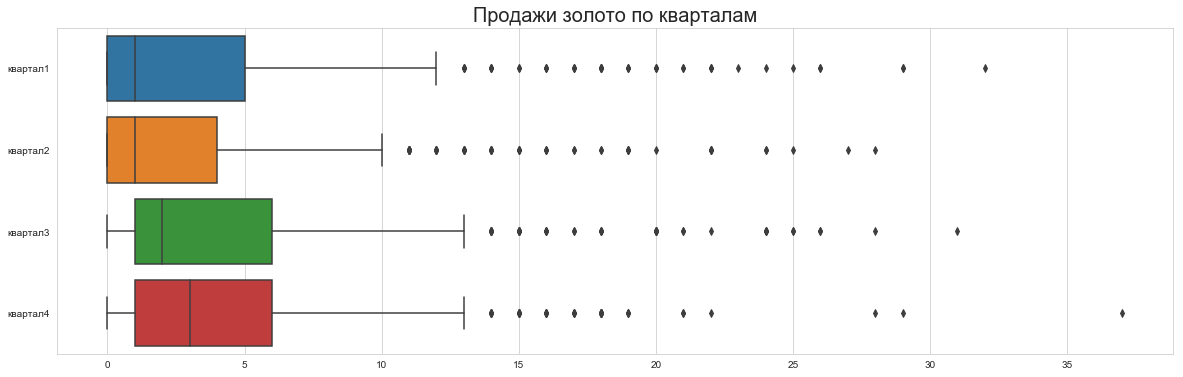

In [499]:
plt.figure(figsize=(20,6))
sns.boxplot(data=sws_q_gold, orient="h").set_title("Продажи золото по кварталам", fontsize=20)

Text(0.5,1,'Продажи серебро по кварталам')

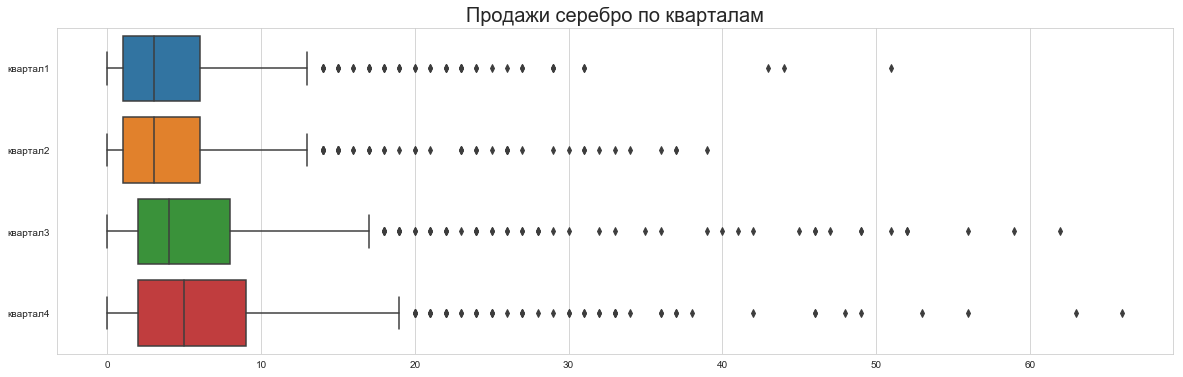

In [512]:
plt.figure(figsize=(20,6))
sns.boxplot(data=sws_q_silver, orient="h").set_title("Продажи серебро по кварталам", fontsize=20)

Text(0.5,1,'Продажи за год')

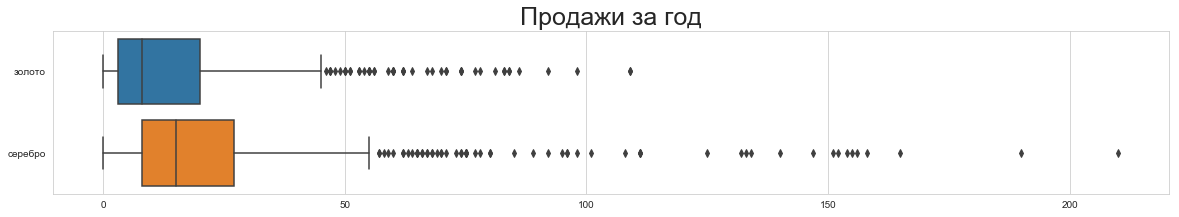

In [507]:
plt.figure(figsize=(20,3))
sns.boxplot(data=sws_y, orient="h").set_title("Продажи за год", fontsize=25)

In [544]:
title = 'Доля магазов с нулевыми продажами'
pd.DataFrame(sws_m_silver.apply(lambda x: (x == 0).sum()/x.sum()), columns=[title]).style.format("{:.0%}")

,Доля магазов с нулевыми продажами
"Январь,2019",28%
"Февраль,2019",23%
"Март,2019",23%
"Апрель,2019",37%
"Май,2019",27%
"Июнь,2019",18%
"Июль,2019",15%
"Август,2019",13%
"Сентябрь,2019",14%
"Октябрь,2019",16%


In [545]:
pd.DataFrame(sws_q_silver.apply(lambda x: (x == 0).sum()/x.sum()), columns=[title]).style.format("{:.0%}")

,Доля магазов с нулевыми продажами
квартал1,4%
квартал2,4%
квартал3,2%
квартал4,1%


In [558]:
title2 = 'Доля магазинов, продажи меньше или равны квантилю'
pd.DataFrame(sws_q_silver.apply(lambda x: (x <= np.percentile(x,25)).sum()/x.sum()), columns=[title2]).style.format("{:.0%}")

,"Доля магазинов, продажи меньше или равны квантилю"
квартал1,6%
квартал2,7%
квартал3,5%
квартал4,4%
